In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


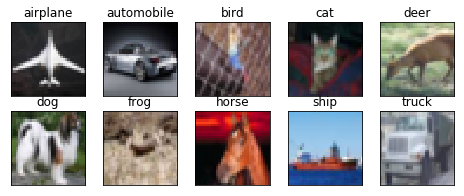

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Helper Functions **

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
   
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_bs2(x):
 return tf.space_to_depth(x, block_size=2)

def space_to_depth_bs4(x):
 return tf.space_to_depth(x, block_size=4)
# x2_block2 = Lambda(space_to_depth_bs2)(x2)

**Model Architecture**  : Defining th ENAS model 

In [0]:
# Input layer
weight_decay = 0.005

img = Input(shape=(32,32,3))
####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
x1 = SeparableConv2D(64, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(img)  #32
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

####################### CONVOLUTION LAYER 5X5 ########################
x2 = Conv2D(64, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x1)   #32
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)

####################### CONVOLUTION LAYER 5X5 ########################
x3 = Conv2D(128, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x2)   #32
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)

x4 = concatenate([x1, x3])

####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
x4 = SeparableConv2D(256, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x4)   #32
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)

m1 = concatenate([x1, x4])

#********************* MAX POOLING LAYER *********************************
m1 = MaxPooling2D(pool_size=(2, 2))(m1)                                        #16
m1 = Conv2D(32, kernel_size=1, activation='relu')(m1)



####################### SEPARABLE CONVOLUTION LAYER 3X3 ########################
y1 = SeparableConv2D(64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(m1)  #16
y1 = BatchNormalization()(y1)
y1 = Dropout(0.2)(y1)

x4_2 = Lambda(space_to_depth_bs2)(x4)
y2 = concatenate([y1, x4_2])

####################### CONVOLUTION LAYER 5X5 ########################
y2 = Conv2D(128, kernel_size=5, padding='same', activation='relu')(y2)          #16
y2 = BatchNormalization()(y2)
y2 = Dropout(0.2)(y2)

x3_2 = Lambda(space_to_depth_bs2)(x3)
y3 = concatenate([x3_2, x4_2, y1, y2])
y3 = Conv2D(128, kernel_size=1)(y3)         #8------------------reduce after concatination of skip connections with 1x1--------------------------------
y3 = BatchNormalization()(y3)
y3 = Activation('relu')(y3)

####################### SEPARABLE CONVOLUTION LAYER 3X3 ########################
y3 = SeparableConv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(y3) #16
y3 = BatchNormalization()(y3)
y3 = Dropout(0.2)(y3)

x1_2 = Lambda(space_to_depth_bs2)(x1)
y4 = concatenate([x1_2, x4_2, y1, y2, y3])
y4 = Conv2D(256, kernel_size=1)(y4)         #8------------------reduce after concatination of skip connections with 1x1--------------------------------
y4 = BatchNormalization()(y4)
y4 = Activation('relu')(y4)

####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
y4 = SeparableConv2D(512, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(y4) #16x16
y4 = BatchNormalization()(y4)
y4 = Dropout(0.2)(y4)

m2 = concatenate([y1, y3, x1_2, x4_2, y4])

#********************* MAX POOLING LAYER *********************************
m2 = MaxPooling2D(pool_size=(2, 2))(m2)                                        #8x8
m2 = Conv2D(32, kernel_size=1, activation='relu')(m2)

y2_2 = Lambda(space_to_depth_bs2)(y2)
m2 = concatenate([y2_2, m2])

####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
z1 = Conv2D(128, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(m2)          #8x8
z1 = BatchNormalization()(z1)
z1 = Dropout(0.2)(z1)

x1_4 = Lambda(space_to_depth_bs4)(x1)
x2_4 = Lambda(space_to_depth_bs4)(x2)
y3_2 = Lambda(space_to_depth_bs2)(y3)
z2 = concatenate([z1, y3_2, x2_4, x1_4])

####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
z2 = SeparableConv2D(256, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(z2) #8
z2 = BatchNormalization()(z2)
z2 = Dropout(0.2)(z2)

x3_4 = Lambda(space_to_depth_bs4)(x3)
x2_4 = Lambda(space_to_depth_bs4)(x2)
y1_2 = Lambda(space_to_depth_bs2)(y1)
z3 = concatenate([z2, y1_2, z1, x3_4, x2_4])
z3 = Conv2D(256, kernel_size=1)(z3)         #8-------------------reduce after concatination of skip connections with 1x1--------------------------------
z3 = BatchNormalization()(z3)
z3 = Activation('relu')(z3)

####################### CONVOLUTION LAYER 3X3 ########################
z3 = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(z3)         #8
z3 = BatchNormalization()(z3)
z3 = Dropout(0.2)(z3)

x4_4 = Lambda(space_to_depth_bs4)(x4)
y1_2 = Lambda(space_to_depth_bs2)(y1)
z4 = concatenate([z3, x3_4, y3_2, z2, x4_4, y1_2, x1_4])
z4 = Conv2D(256, kernel_size=1)(z4)         #8-------------------reduce after concatination of skip connections with 1x1--------------------------------
z4 = BatchNormalization()(z4)
z4 = Activation('relu')(z4)

####################### SEPARABLE CONVOLUTION LAYER 5X5 ########################
z4 = SeparableConv2D(1024, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(z4) #8
z4 = BatchNormalization()(z4)
z4 = Dropout(0.2)(z4)

z5 = concatenate([z4, z2, x4_4, y3_2])
z5 = Conv2D(10, kernel_size=1)(z5)         #8---------------------reduce after concatination of skip connections with 1x1--------------------------------
z5 = BatchNormalization()(z5)
z5 = Activation('relu')(z5)


# z5 = Conv2D(10, kernel_size=8)(z5) #8
# z5 = AveragePooling2D(8)(z5)
z5 = GlobalAveragePooling2D()(z5)
# z5 = Conv2D(10, kernel_size=1)(z5)
# z5 = Flatten()(z5)
# z5 = Dense(10)(z5)
output = Activation('softmax')(z5)


model = Model(inputs=[img], outputs=output)
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_15 (SeparableC (None, 32, 32, 64)   331         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 32, 32, 64)   256         separable_conv2d_15[0][0]        
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_25 

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 187s 479ms/step - loss: 1.6856 - acc: 0.5227 - val_loss: 1.4391 - val_acc: 0.5687
Epoch 2/100
390/390 [==============================] - 180s 461ms/step - loss: 1.0998 - acc: 0.6978 - val_loss: 1.1039 - val_acc: 0.6927
Epoch 3/100
390/390 [==============================] - 180s 461ms/step - loss: 0.8997 - acc: 0.7601 - val_loss: 0.9903 - val_acc: 0.7220
Epoch 4/100
390/390 [==============================] - 180s 461ms/step - loss: 0.7731 - acc: 0.7990 - val_loss: 1.0052 - val_acc: 0.7180
Epoch 5/100
390/390 [==============================] - 179s 460ms/step - loss: 0.6713 - acc: 0.8300 - val_loss: 0.8084 - val_acc: 0.7806
Epoch 6/100
390/390 [==============================] - 179s 460ms/step - loss: 0.5930 - acc: 0.8525 - val_loss: 1.2196 - val_acc: 0.6646
Epoch 7/100
390/390 [==============================] - 179s 460ms/step - loss: 0.5212 - acc: 0.8709 - val_loss: 0.8733 - val_acc: 0.7677
Epoch 8/100
390/390 [====================

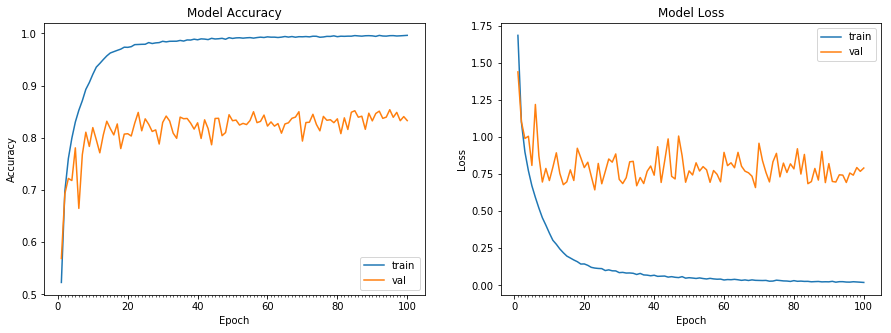

Accuracy on test data is: 83.28


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))